In [1]:
from functools import partial

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sympy as sy
import y0
from sklearn.metrics import r2_score
from y0.dsl import Variable
from y0.graph import NxMixedGraph

from nocap import scm, utility

np.random.seed(42)
#!pip install pgmpy

## load e. coli network

In [2]:
ecoli_filepath = "./ecoli/ecoli_full_network_no_small_rna.graphml"
ecoli_network = nx.read_graphml(ecoli_filepath)

## get fadR subnetwork

In [3]:
# fadR
fadr_graph = utility.get_subgraph_from_nodes(ecoli_network, ["fadR"], descendants_only=False)
fadr_graph_dag = utility.convert_to_acyclic_graph(fadr_graph, "fadR")
fadr_graph_mixed = NxMixedGraph.from_str_edges(directed=fadr_graph_dag.edges)

print(f"{len(fadr_graph_mixed.directed.nodes)} nodes")
print(f"{len(fadr_graph_mixed.directed.edges)} edges")

109 nodes
421 edges


## simulate data for fadR subnetwork using linear model

In [4]:
# fadr_node_generators = {
#     node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
# }
# fadr_edge_weights = {
#     edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_node_generators = {
    node: partial(np.random.normal, loc=0, scale=1) for node in fadr_graph_mixed.nodes()
}
# fadr_edge_weights = {
#     edge: np.random.uniform(low=-1, high=1) for edge in fadr_graph_mixed.directed.edges()
# }

fadr_edge_weights = {
    edge: np.random.normal(loc=0, scale=1) for edge in fadr_graph_mixed.directed.edges()
}

n_samples = 10000

fadr_df_lscm = scm.simulate_lscm(
    graph=fadr_graph_mixed,
    node_generators=fadr_node_generators,
    edge_weights=fadr_edge_weights,
    n_samples=n_samples,
)

print(fadr_df_lscm.head())

       basR      nsrR      glrR      ptrR      btsR      dksA     c0293  \
0  1.755341 -0.248964  0.971571  0.645376  1.368632 -0.964923  0.686051   
1  0.638592 -1.661520 -0.066080 -1.211016 -0.651836  0.047399 -0.860413   
2 -1.295079 -0.335785  1.669022 -0.259591 -1.503143 -0.245743 -0.272724   
3 -0.611518 -1.406661 -0.923233 -1.351685 -0.975873  1.053642 -0.949399   
4  0.471416 -0.552223  0.632932  0.202923 -1.515744  1.547505  1.795878   

        hns      fabR      arcA  ...       marA       gadE       rcsA  \
0  1.058424 -1.758739 -1.183259  ...   0.921813 -16.893566 -14.576871   
1 -0.384556  1.006293 -0.576892  ...  12.684636  24.515829  -7.334145   
2 -2.696887 -0.054295 -0.230935  ...  14.170592  37.885493  -9.074074   
3  2.632382  0.493318  0.184836  ...  -6.793701 -47.303130  12.309171   
4 -0.612789 -0.387702  0.285865  ...   6.267180 -25.473576  17.750309   

        csgD      flhC       flhD       iclR       aceA       aceB       aceK  
0 -21.904021  8.533226  24.166

## calibrate linear fadR model to data

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_80602/2912437397.py:1: UserWarning: Correlation matrix contains 20 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 11.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_80602/2912437397.py:1: UserWarning: Correlation matrix contains 3 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 4.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_80602/2912437397.py:1: UserWarning: Correlation matrix contains 29 off-diagonal elements with absolute values greater than the threshold of 0.8. Total number of variables: 13.
  fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)
/var/folders/kc/g6

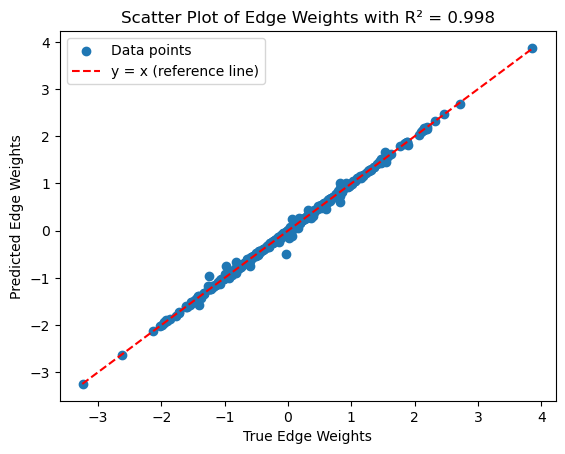

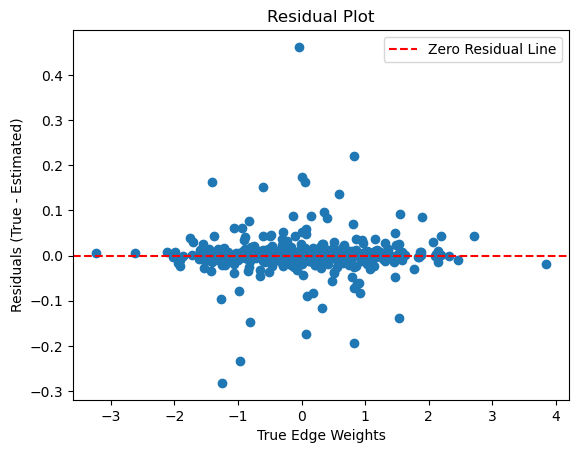

In [24]:
fadr_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_df_lscm)


def plot_scatter_with_r2(exp_edges, pred_edges):
    exp_values = np.array([exp_edges[edge] for edge in exp_edges])
    pred_values = np.array([pred_edges[edge] for edge in pred_edges])

    # Calculate R^2 value
    r2 = r2_score(exp_values, pred_values)

    # Create scatter plot
    plt.scatter(exp_values, pred_values, label="Data points")
    max_val = max(np.max(exp_values), np.max(pred_values))
    min_val = min(np.min(exp_values), np.min(pred_values))
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Predicted Edge Weights")
    plt.title(f"Scatter Plot of Edge Weights with R² = {r2:.3f}")
    plt.legend()
    plt.show()


def plot_residuals(true_weights, estimated_weights):
    true_values = np.array([value for value in true_weights.values()])
    estimated_values = np.array([value for value in estimated_weights.values()])

    # Calculate residuals
    residuals = true_values - estimated_values

    # Scatter plot of residuals
    plt.scatter(true_values, residuals)
    plt.axhline(0, color="r", linestyle="--", label="Zero Residual Line")
    plt.xlabel("True Edge Weights")
    plt.ylabel("Residuals (True - Estimated)")
    plt.title("Residual Plot")
    plt.legend()
    plt.show()


# Example usage
plot_scatter_with_r2(fadr_edge_weights, fadr_edge_weight_estimates)

plot_residuals(fadr_edge_weights, fadr_edge_weight_estimates)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  2.,  4.,  1.,  1.,  2.,  1.,  4.,  5.,  6.,
         4.,  1.,  8.,  7.,  3.,  8.,  9.,  6., 16., 11.,  8., 12., 14.,
        10.,  8.,  9., 14., 11.,  7., 13., 13., 11., 13., 20., 14.,  7.,
        14.,  9., 14.,  6., 12.,  7.,  8.,  9.,  3.,  8.,  3.,  4.,  3.,
         3.,  7.,  3.,  2.,  1.,  1.,  5.,  1.,  0.,  1.,  5.,  2.,  0.,
         1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.24665012, -3.17546748, -3.10428483, -3.03310219, -2.96191955,
        -2.89073691, -2.81955426, -2.74837162, -2.67718898, -2.60600633,
        -2.53482369, -2.46364105, -2.39245841, -2.32127576, -2.25009312,
        -2.17891048, -2.10772784, -2.03654519, -1.96536255, -1.89417991,
        -1.82299727, -1.75181462, -1.68063198, -1.60944934, -1.5382667 ,
        -1.46708405, -1.39590141, -1.32471877, -1.25353612, -1.182353

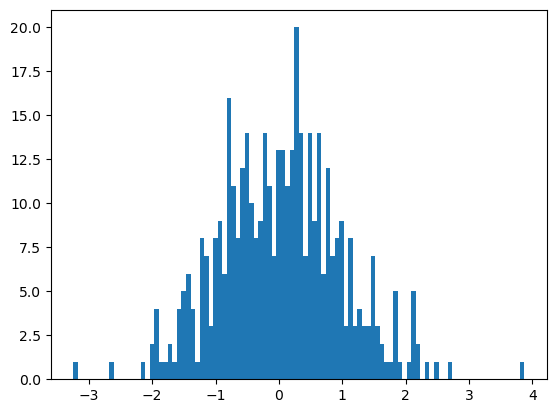

In [6]:
fadr_edge_weight_values = np.array([value for value in fadr_edge_weights.values()])
fadr_edge_weight_values_predicted = np.array(
    [value for value in fadr_edge_weight_estimates.values()]
)

#plt.hist(fadr_edge_weight_values, bins=100)
plt.hist(fadr_edge_weight_values_predicted, bins=100)

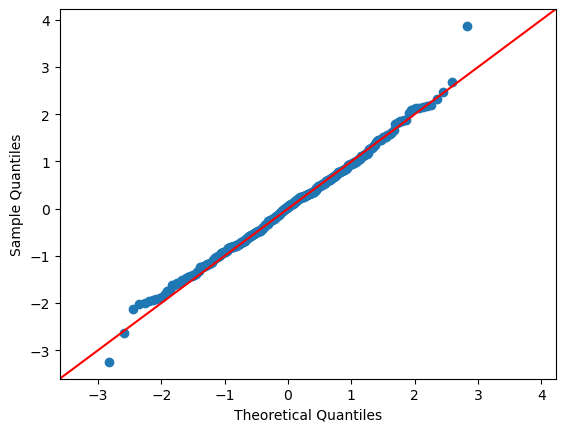

In [7]:
import numpy as np
import pylab as py
import statsmodels.api as sm

# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code
# the graph look different than shown below.

# Random data points generated
data_points = np.array([v for v in fadr_edge_weight_estimates.values()])

# fadr_edge_weight_estimates

sm.qqplot(data_points, line="45")
py.show()

## perform intervention on fadR subnetwork and simulate interventional data from calibrated model

In [8]:
fadr_intervened_lscm_calibrated = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weight_estimates,
)

fadr_df_lscm_calibrated_intervened = pd.DataFrame(
    {
        trial: {
            variable.name: values
            for variable, values in fadr_intervened_lscm_calibrated.trial().items()
        }
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_calibrated_intervened.head())

       basR      nsrR      glrR      ptrR      btsR      dksA  fadR     c0293  \
0 -0.937164 -0.796979 -0.391399  0.711297  0.075460 -2.650032  10.0 -0.375435   
1  0.246876  0.934023  0.298862 -0.445368  1.937376 -0.438234  10.0 -0.280874   
2 -1.631501  2.278406 -1.206552  0.401716 -0.191333 -0.305587  10.0  1.094475   
3 -0.070744 -0.991710  2.470659  0.038141 -1.277910 -0.152327  10.0 -0.026510   
4 -2.045530 -1.479853  0.806480  0.486937 -1.470096  0.823752  10.0  0.885780   

        hns      fabR  ...       marA       gadE       rcsA       csgD  \
0  0.241630  2.001779  ...   4.405936  73.039608 -32.287808 -62.259608   
1 -1.864315  0.041102  ...   9.298844  79.215238 -11.938158 -14.808460   
2  0.984903 -0.376815  ...  -7.146905  -5.183486  -2.728927  -8.652853   
3  0.320648  0.987835  ... -10.704192 -41.205074  -3.819702 -21.427836   
4  0.629885  2.527765  ...  -5.280638 -96.242073   4.142714 -18.175858   

       flhC       flhD       iclR       aceA       aceB       aceK  

## perform intervention on fadR subnetwork and simulate interventional data from actual model

In [9]:
fadr_intervened_lscm = scm.intervene_on_lscm(
    original_graph=fadr_graph_mixed,
    intervention_node=((Variable("fadR"), 10.0)),
    original_node_generators=fadr_node_generators,
    original_edge_weights=fadr_edge_weights,
)

fadr_df_lscm_intervened = pd.DataFrame(
    {
        trial: {variable.name: values for variable, values in fadr_intervened_lscm.trial().items()}
        for trial in range(n_samples)
    }
).T

print(fadr_df_lscm_intervened.head())

       basR      nsrR      glrR      ptrR      btsR      dksA  fadR     c0293  \
0 -1.012423  0.127556  0.248795  0.594025  0.338711 -1.505818  10.0 -0.674897   
1  1.028878 -1.014205  0.366080 -0.602626 -0.674181  0.919657  10.0  0.528825   
2 -1.478127 -1.034599  0.540847  0.287502 -0.612047 -0.003312  10.0  0.523069   
3  1.188219  0.704424  1.156018 -0.267383  0.376457  0.094873  10.0  1.414352   
4  1.356585 -0.326937  0.636341 -0.721570 -0.646495 -1.458236  10.0  0.602267   

        hns      fabR  ...      marA       gadE       rcsA       csgD  \
0 -1.323337  1.284469  ... -3.861582  -5.450341  -8.088338 -34.310662   
1 -1.502337 -1.141560  ...  3.153645 -21.102206  11.927063  11.411540   
2  1.064281  1.238801  ...  5.203010  -0.721850  -5.723804  -8.866071   
3 -0.119856 -0.770633  ... -1.738368  -6.002303   0.477862  -8.194677   
4  0.458250 -0.486197  ...  1.377746  31.837336 -18.395640 -28.217216   

       flhC       flhD       iclR       aceA       aceB       aceK  
0  1.

## calculate expected and predicted average treatment effect of fadR linear model

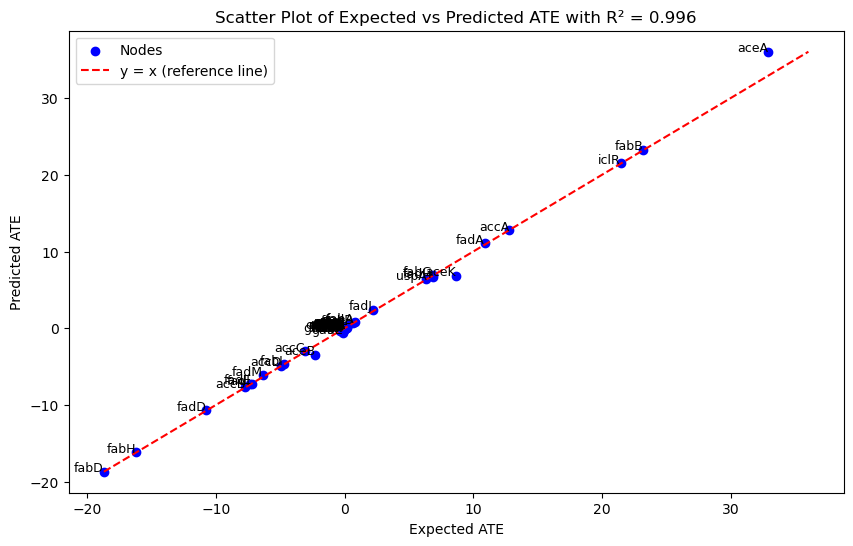

In [23]:
targets_list = [
    node for node in fadr_graph_mixed.nodes() if node.name != "fadR"
]  # all nodes except intervened node 'fadR'


expected_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_intervened, targets_list
)
predicted_fadr_ATE = scm.compute_average_treatment_effect(
    fadr_df_lscm, fadr_df_lscm_calibrated_intervened, targets_list
)

# print(f"expected ATE:{expected_fadr_ATE}")
# print(f"actual ATE:{predicted_fadr_ATE}")


# Extract values in the same order
expected_values = np.array([expected_fadr_ATE[node] for node in expected_fadr_ATE])
predicted_values = np.array([predicted_fadr_ATE[node] for node in predicted_fadr_ATE])

# Calculate R2 value
r2 = r2_score(expected_values, predicted_values)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(expected_values, predicted_values, color="blue", label="Nodes")

# Add node labels
for i, node in enumerate(expected_fadr_ATE.keys()):
    plt.text(expected_values[i], predicted_values[i], node, fontsize=9, ha="right")

# Reference line (y=x)
max_val = max(np.max(expected_values), np.max(predicted_values))
min_val = min(np.min(expected_values), np.min(predicted_values))
plt.plot([min_val, max_val], [min_val, max_val], "r--", label=f"y = x (reference line)")

# Add labels and title
plt.xlabel("Expected ATE")
plt.ylabel("Predicted ATE")
plt.title(f"Scatter Plot of Expected vs Predicted ATE with R² = {r2:.3f}")
plt.legend()

plt.show()

## Non-linear data generation using SERGIO (modified Hill equation)

In [11]:
import sys

sys.path.append("/Users/geor228/Github/SERGIO")  # TODO: fix this
from SERGIO import gene, sergio

### SERGIO wrapper functions and test

In [15]:
def simulate_SERGIO(number_genes, number_bins, targets_file, regs_file, mapping, number_sc=100):
    """Simulate SERGIO and return gene expression dataframes clean and also with technical noise added."""
    sim = sergio.sergio(
        number_genes,
        number_bins,
        number_sc=number_sc,
        noise_params=1,
        noise_type="dpd",
        decays=0.8,
        sampling_state=15,
    )
    sim.build_graph(input_file_taregts=targets_file, input_file_regs=regs_file, shared_coop_state=0)
    sim.simulate()
    expr = sim.getExpressions()

    # get clean expression (steady state) dataframe
    expr_clean_ss = np.concatenate(expr, axis=1)
    df_output = pd.DataFrame(expr_clean_ss)
    gene_mapping = df_output.index.map(mapping)
    df_output.insert(0, "gene", gene_mapping)
    
    # get expression w/ technical noise dataframe
    # outlier
    expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 0.8, scale = 1)
    # library size
    libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.6, scale = 0.4)
    # dropout
    binary_ind = sim.dropout_indicator(expr_O_L, shape = 6.5, percentile = 82)
    expr_O_L_D = np.multiply(binary_ind, expr_O_L)
    # UMI
    count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)
    count_matrix = np.concatenate(count_matrix, axis = 1)
    df_output_noise = pd.DataFrame(count_matrix)
    print(df_output_noise)
    df_output_noise.insert(0, "gene", gene_mapping)

    assert not df_output.equals(df_output_noise), "DataFrames should not be equal."
  
    return df_output, df_output_noise


def generate_sergio_data(
    target_gene,
    gene_network,
    base_param_distributions,
    n_replicas,
    targets_filename,
    regs_filename,
    seed=0,
    draw_network_layout=True,
    network_filename=None,
    data_filename=None,
    sergio_clean_outname="sergio_data_clean.csv",
    sergio_noise_outname="sergio_data_noise.csv",
    number_sc = 10
):
    # Set the random seed
    np.random.seed(seed)

    # Get subgraph for the target gene
    network_all = utility.get_subgraph_from_nodes(gene_network, [target_gene], descendants_only=False)
    network_dag = utility.convert_to_acyclic_graph(network_all, target_gene)
    # Optionally draw the network
    if draw_network_layout:
        utility.draw_network(network_dag)
    # Optionally save the network to a file
    if network_filename is not None:
        nx.write_gml(network_dag, f"{network_filename}")

    # Define distribution settings for the parameters
    param_distributions = base_param_distributions.copy()
    master_regulators = [node for node, indegree in network_dag.in_degree() if indegree == 0]

    for replica_id, param_dist in param_distributions.items():
        param_dist["master_regulators"]= master_regulators

    #param_distributions["master_regulators"] = master_regulators

    # Generate hill equations and random parameter values from distribution
    all_replica_equations = utility.generate_hill_equations_for_n_replicas(
        network_dag, activation_probability=0.5, n=n_replicas
    )
    all_parameter_values = utility.assign_random_values_for_n_replicas(
        all_replica_equations, param_distributions
    )
    print("All parameter values dict:", all_parameter_values)

    if data_filename is not None:
        utility.write_equation_info_to_file(all_replica_equations, all_parameter_values, data_filename)

    # Convert to SERGIO compatible data and save to file
    node_to_idx = utility.create_node_to_idx_mapping(network_dag)
    print(node_to_idx)
    idx_to_node = {v: k for k, v in node_to_idx.items()}
    print(idx_to_node)
    # Adjust the keys in all_parameter_values to start from 1 if necessary
    all_targets_dfs, all_regs_dfs = utility.create_dataframes_for_sergio_inputs_from_n_replicas(
        network_dag, all_parameter_values, node_to_idx
    )
    targets_df, regs_df = utility.merge_n_replica_dataframes_for_sergio_inputs(
        all_targets_dfs, all_regs_dfs, merge_type="first_only"
    )
    utility.write_input_files_for_sergio(targets_df, regs_df, targets_filename, regs_filename)
    mapping = idx_to_node
    # Validate SERGIO inputs
    df_clean, df_noise = simulate_SERGIO(number_genes=len(network_dag.nodes()),
                    number_bins=n_replicas,
                    targets_file=targets_filename,
                    regs_file=regs_filename,
                    mapping=mapping, 
                    number_sc=number_sc)
    df_clean.to_csv(sergio_clean_outname)
    df_noise.to_csv(sergio_noise_outname)

    return df_clean, df_noise


# Test case function
def test_generate_sergio_data():
    # Create a basic directed graph with a single self-loop and a cycle
    gene_network = nx.DiGraph()
    gene_network.add_edge("Gene1", "Gene1", polarity="+")  # Self-loop
    gene_network.add_edge("Gene1", "Gene2", polarity="-")
    gene_network.add_edge("Gene2", "Gene3", polarity="+/-")
    gene_network.add_edge("Gene3", "Gene1", polarity="")  # Cycle

    # Define base parameter distributions (mock dictionary)
    base_param_distributions1 = {
        "K": {"min": 1, "max": 5},
        "n": {"min": 1, "max": 3},
        "h": {"min": 1, "max": 5},
        "b": {"a": 2, "b": 5, "scale": 4},
    }
    base_param_distributions2 = {
        "K": {"min": 1, "max": 5},
        "n": {"min": 1, "max": 3},
        "h": {"min": 1, "max": 5},
        "b": {"a": 2, "b": 5, "scale": 40},
    }

    base_param_distributions = {
        0: base_param_distributions1,
        1: base_param_distributions2
    }

    # Call the generate_sergio_data function with the test graph and parameters
    generate_sergio_data(
        target_gene="Gene1",
        gene_network=gene_network,
        base_param_distributions=base_param_distributions,
        n_replicas=2,
        targets_filename="test_targets_2_bins.csv",
        regs_filename="test_regs_2_bins.csv",
        seed=42,
        draw_network_layout=False,  # Disable drawing for the test
        network_filename="test_graph_2_bins.graphml",
        data_filename="test_eqns_and_params_2_bins.txt",
        sergio_clean_outname="test_sergio_data_clean.csv",
        sergio_noise_outname="test_sergio_data_noise.csv",
        number_sc = 10
    )

    print("Test passed for generate_sergio_data.")


# Run the test case function
test_generate_sergio_data()


All parameter values dict: {0: {b_Gene1: 0.9266506169490132, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 1.2323344486727978, K_Gene2_Gene3: 4.46470458309974, n_Gene1_Gene2: 3, n_Gene2_Gene3: 2, h_Gene1_Gene2: 1.225646316108401, h_Gene2_Gene3: 3.887995089067299}, 1: {b_Gene1: 12.336193759326964, b_Gene2: 0, b_Gene3: 0, K_Gene1_Gene2: 4.895022075365837, K_Gene2_Gene3: 1.931085361721217, n_Gene1_Gene2: 2, n_Gene2_Gene3: 3, h_Gene1_Gene2: 3.473544037332349, h_Gene2_Gene3: 2.529847965068651}}
{'Gene1': 0, 'Gene2': 1, 'Gene3': 2}
{0: 'Gene1', 1: 'Gene2', 2: 'Gene3'}
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
Start simulating new level
There are 1 genes to simulate in this layer
Done with current level
   0   1   2   3   4   5   6   7    8   9   10   11   12  13   14  15   16  \
0   0   0   0   0   0   0   0   0    0   0   0  121  133   0  127   0  134 

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_80602/2249864344.py:80: UserWarning: using replica in range(N) - ensure replica id is 0 index.
  all_replica_equations = utility.generate_hill_equations_for_n_replicas(


## Nominal data for fadR

In [35]:
# sergio data

# arbitrary parameter value choices (approx from data)
base_param_distributions1 = {
    "K": {"min": 1, "max": 5},
    "n": {"min": 1, "max": 3},
    "h": {"min": 1, "max": 5},
    "b": {"a": 2, "b": 5, "scale": 4},
}

base_param_distributions = {
    0: base_param_distributions1,
}


fadr_nominal_df_wo_noise_T, fadr_nominal_df_w_noise_T = generate_sergio_data(
    target_gene="fadR",
    gene_network=fadr_graph_dag,
    base_param_distributions=base_param_distributions,
    n_replicas=1,
    targets_filename="fadR_targets.csv",
    regs_filename="fadR_regs.csv",
    seed=42,
    draw_network_layout=False,
    network_filename=None,
    data_filename="fadR_eqns_and_params.txt",
    sergio_clean_outname="fadR_sergio_df_clean.csv",
    sergio_noise_outname="fadR_sergio_df_noise.csv",
    number_sc=100
)

fadr_nominal_df_wo_noise = fadr_nominal_df_wo_noise_T.set_index('gene').T

# microsplit data

/var/folders/kc/g6x5cwr96dn6lx9m4bq_4m_h0000gn/T/ipykernel_80602/2249864344.py:80: UserWarning: using replica in range(N) - ensure replica id is 0 index.
  all_replica_equations = utility.generate_hill_equations_for_n_replicas(


All parameter values dict: {0: {b_nac: 0, b_basR: 0.9343168631926071, b_nsrR: 0.2963006869245133, b_glrR: 1.0036903474157555, b_fadJ: 0, b_cra: 0, b_crp: 0, b_fabA: 0, b_yjjQ: 0, b_uspA: 0, b_torR: 0, b_glnG: 0, b_dnaA: 0, b_pdhR: 0, b_fadA: 0, b_accA: 0, b_ptrR: 1.768066998134406, b_lrp: 0, b_argP: 0, b_argR: 0, b_btsR: 0.379104292052907, b_slyA: 0, b_phoB: 0, b_aceB: 0, b_evgA: 0, b_dksA: 0.7931618876533778, b_fabB: 0, b_fabG: 0, b_rutR: 0, b_c0293: 1.5049471528541998, b_fliZ: 0, b_lldR: 0, b_hipB: 0, b_adiY: 0, b_ompR: 0, b_hns: 2.17386721617813, b_fliA: 0, b_aceA: 0, b_flhD: 0, b_fnr: 0, b_fabD: 0, b_lrhA: 0, b_hdfR: 0, b_soxS: 0, b_accB: 0, b_accC: 0, b_flhC: 0, b_gadW: 0, b_gadE: 0, b_deaD: 0, b_fabR: 0.3390550517706009, b_ydeO: 0, b_gadX: 0, b_fis: 0, b_cytR: 0, b_rpoS: 0, b_stpA: 0, b_phoP: 0, b_qseB: 0, b_arcA: 1.4317151711358436, b_fur: 0, b_mqsA: 1.0932830958015296, b_accD: 0, b_fadH: 0, b_fadD: 0, b_aceK: 0, b_fadR: 0, b_ihfA: 0, b_fadB: 0, b_rpsA: 0, b_fabH: 0, b_fadI: 0, 

In [38]:


print(fadr_nominal_df_wo_noise.head())



gene        nac      basR      nsrR      glrR      fadJ       cra       crp  \
0      2.539225  0.074039  0.156441  0.700229  9.395751  1.802796  2.451773   
1      5.793636  1.372863  0.262005  0.587055  7.854851  1.592289  0.874040   
2      5.832950  0.752532  1.451922  1.311186  9.831013  0.615634  0.010325   
3     10.083391  0.800528  1.199328  1.600786  5.130108  2.983148  4.236114   
4      4.943719  0.168149  0.890601  1.771747  5.565280  3.261769  1.713764   

gene      fabA       yjjQ       uspA  ...       fadM      glaR      iclR  \
0     6.617658  11.801640   9.836206  ...   3.113521  2.337847  5.509839   
1     8.390519   8.209558  11.007477  ...   1.585052  3.418766  5.752163   
2     8.100315  14.349751   9.789632  ...  11.254400  4.244088  8.904676   
3     2.000649   7.981916   8.460074  ...   6.314074  3.250699  4.788769   
4     7.475627   8.988097   7.207316  ...   6.132817  2.040488  3.477003   

gene      zraR      rpoN      bglJ      acrR      matA       rcsA   

## calibrate linear model to data from non-linear fadR model

In [40]:
print(fadr_nominal_df_wo_noise['marR'])

#fadr_nominal_sergio_edge_weight_estimates = scm.calibrate_lscm(graph=fadr_graph_mixed, data=fadr_nominal_df_wo_noise)

KeyError: 'marR'

In [ ]:
fadr_intervened_data_expected = 0

fadr_intervened_data_predicted = 0

fadr_ate_expected = 0

fadr_ate_predicted = 0
